# FordGo BikeShare Data 
Date Ranges: June 2017 - November 2018<br>
Data Source: https://s3.amazonaws.com/fordgobike-data/index.html <br>
NOTE: User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)<br>

## Table of Contents
#### [Data Setup](#data-setup)
* [Importing Packages](#import-packages) 
* [Importing the Data](#import-data) 
* [Cleaning Formats](#clean-data) 
* [Outliers](#outliers) 
* [Null Values](#bull-values) 

#### [Exploratory Data Analysis](#eda)
* [General](#general) 
* [Time Series](#time-series)
* [Subscriber vs Customer](#sub_vs_cust)
* [Age](#age)
* [Gender](#gender)

<br> 
## Data Setup <a class="anchor" id="data-setup"></a> <br>

### Importing Packages <a class="anchor" id="import-packages"></a> <br>

In [289]:
# Import Packages
import glob
import pandas as pd 
import numpy as np
import datetime as dt
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from collections import Counter
import statsmodels.api as sm

<br>

### Importing Data <a class="anchor" id="import-data"></a>
NOTES: 
* 2017 data is from July to December and is all in a single file
* 2018 dats is broken down by month and each month has it's own data file. 
* Because the data is broken up in this manner, I've placed all CSVs into a folder and I'm using Glob to grab all datasets. 

In [290]:
# Glob all files
all_files = glob.glob(path + "/*.csv")

# Concat all files to create dataframe
df = pd.concat((pd.read_csv(f) for f in all_files), sort=False)

In [291]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,79489,2018-11-30 13:40:32.7690,2018-12-01 11:45:21.9720,NaN,NaN,37.420000,-121.940000,NaN,NaN,37.410000,-121.940000,4105,Customer,1982.0,Female,No
1,42847,2018-11-30 20:13:45.5090,2018-12-01 08:07:53.1330,37.0,2nd St at Folsom St,37.785000,-122.395936,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,2614,Customer,1992.0,Male,No
2,1128,2018-11-30 23:58:26.4310,2018-12-01 00:17:14.4880,249.0,Russell St at College Ave,37.858473,-122.253253,249.0,Russell St at College Ave,37.858473,-122.253253,1496,Subscriber,1998.0,Male,Yes
3,2476,2018-11-30 23:35:06.7230,2018-12-01 00:16:23.4740,104.0,4th St at 16th St,37.767045,-122.390833,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,1334,Subscriber,1959.0,Male,No
4,1273,2018-11-30 23:54:12.3890,2018-12-01 00:15:26.3680,44.0,Civic Center/UN Plaza BART Station (Market St ...,37.781074,-122.411738,60.0,8th St at Ringold St,37.774520,-122.409449,393,Subscriber,1993.0,Female,Yes


<br>

### Clean Formats of Data <a class="anchor" id="clean-data"></a>
We know that there are 2 datetime columns in the dataset (start_time & end_time). Here, we will convert those columns to datetime

In [292]:
# Convert to Datetime
df['start_time'] =  pd.to_datetime(df['start_time'])
df['end_time'] =  pd.to_datetime(df['end_time'])

In [293]:
# View the dtypes
df.dtypes

duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                  float64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                          object
member_birth_year                 float64
member_gender                      object
bike_share_for_all_trip            object
dtype: object

<br>

### Outliers <a class="anchor" id="outliers"></a> 
Remove trips greater than 8 hours and less than 1 minute. We are filtering because there are a few trips that lasted longer than 8 hours. This could be a technology error or someone may not have returned the bike. We've also filtered our trips less than 5 minutes because these could have been accidental rentals.<br><br>
To make things a little easier, let's create a minutes column instead of seconds. 

In [294]:
df_clean = df[(df.duration_sec <= 28800) & (df.duration_sec >= 60)] # greater than 12 hours in seconds & less than 1 minute

In [295]:
print('Shape Before:', df.shape)
print('Shape After:', df_clean.shape)
print('Total Number of Rows Lost:', (len(df) - len(df_clean)))

Shape Before: (2252058, 16)
Shape After: (2248026, 16)
Total Number of Rows Lost: 4032


<br>

### Null Values <a class="anchor" id="null-values"></a> 
Check for null values in dataset

In [193]:
df_clean.isnull().sum()

duration_sec                    0
start_time                      0
end_time                        0
start_station_id            11518
start_station_name          11518
start_station_latitude          0
start_station_longitude         0
end_station_id              11518
end_station_name            11518
end_station_latitude            0
end_station_longitude           0
bike_id                         0
user_type                       0
member_birth_year          171263
member_gender              170833
bike_share_for_all_trip    518718
duration_min                    0
dtype: int64

There are quite a few missing values in this dataset. First, let's drop the data with missing station names & IDs. We will need this information in later analysis. 

In [296]:
# Drop NA's from these two columns. This will subsequently drop the start_station_name & end_station_name 
df_clean = df_clean.dropna(subset=['start_station_id', 'end_station_id'])

# Print shape
df_clean.shape

(2236520, 16)

In [205]:
# Old shape vs new shape
2249404 - 2237886

11518

Great! We can see that the dropped values is the same as the number of missing values from above. <br><br>
Now lets' take a look at bike_share_for_all_trip, member_birth_year, and member_gender. In this case, it doesn't make sense to attempt to estimate the member birth year and gender. But, we can update the blank values in the bike_share_for_all_trip column.

In [297]:
# Look for unique values in the bike_share_for_all_trip column
df_clean.bike_share_for_all_trip.unique()

array(['Yes', 'No', nan], dtype=object)

Cool, looks like it's yes and no. bike_share_for_all_trip means the customer rented the bike for the full day. Meaning, they had a flat price. With that in mind, we can assume all the nan values are equal to no. Let's replace that now. 

In [298]:
# Fill in NAs with No
df_clean.bike_share_for_all_trip.fillna('No', inplace=True)

<br>

## EDA <a class="anchor" id="eda"></a>

<br>

### General Information <a class="anchor" id="general"></a>

In [299]:
# We will reference the color variable in later graphs
clr = ['#5F156A', '#E14F40']
color = cm.inferno_r(np.linspace(.4,.8, 30))

In [208]:
# Percentages of Subscribers & Customers
df_clean['user_type'].value_counts() / df_clean['user_type'].count()

Subscriber    0.835306
Customer      0.164694
Name: user_type, dtype: float64

Interesting.. 83% of the trips are subscribers. <br>
As a refresher, subscribers are those who pay a flat, monthly fee for unlimited rides. Customers pay for single rides or pay for the day.<br>
This is interesting because we know the majority of our riders are most likely locals who use the service for commuting. We can explore that assumption more below. 

<br>

### Time Series <a class="anchor" id="time-series"></a>

[Text(0, 0, '12am'),
 Text(0, 0, '1am'),
 Text(0, 0, '2am'),
 Text(0, 0, '3am'),
 Text(0, 0, '4am'),
 Text(0, 0, '5am'),
 Text(0, 0, '6am'),
 Text(0, 0, '7am'),
 Text(0, 0, '8am'),
 Text(0, 0, '9am'),
 Text(0, 0, '10am'),
 Text(0, 0, '11am'),
 Text(0, 0, '12am'),
 Text(0, 0, '1pm'),
 Text(0, 0, '2pm'),
 Text(0, 0, '3pm'),
 Text(0, 0, '4pm'),
 Text(0, 0, '5pm'),
 Text(0, 0, '6pm'),
 Text(0, 0, '7pm'),
 Text(0, 0, '8pm'),
 Text(0, 0, '9pm'),
 Text(0, 0, '10pm'),
 Text(0, 0, '11pm')]

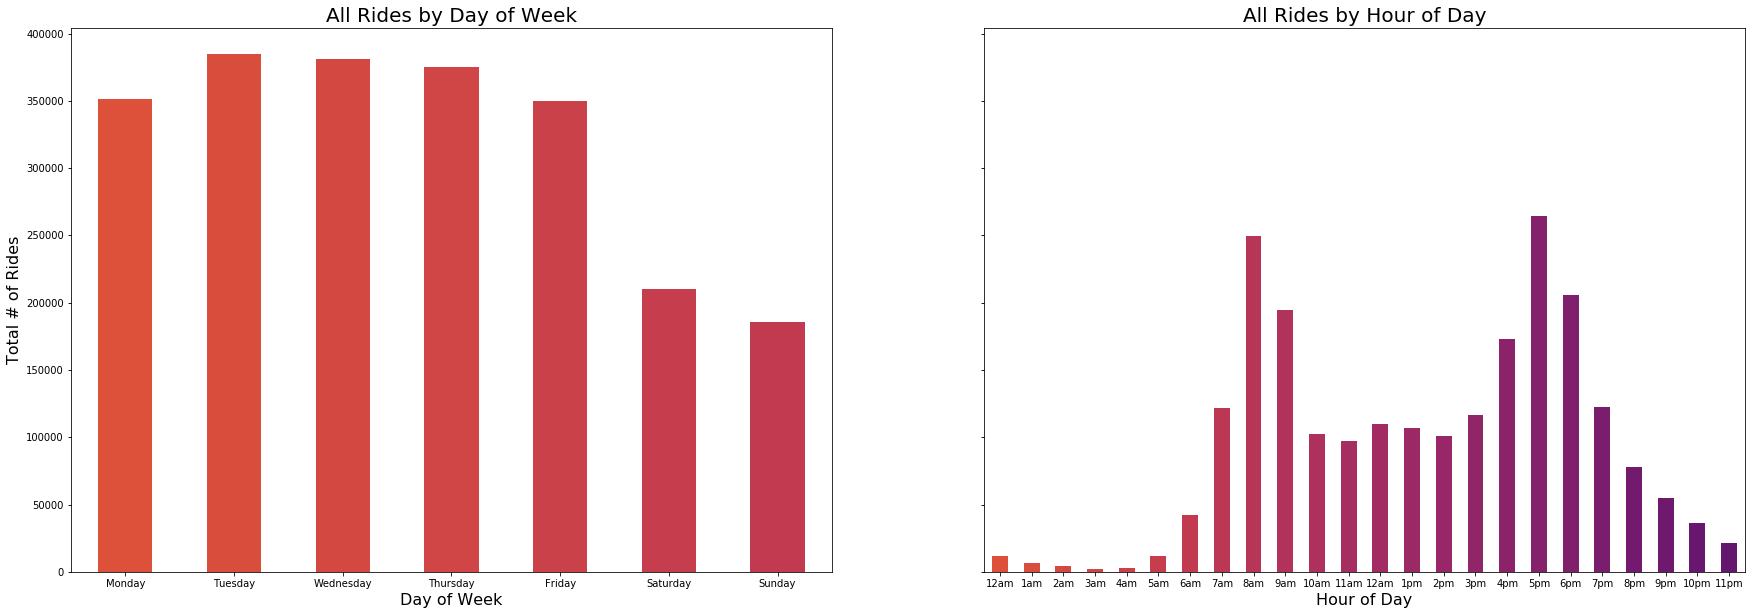

In [235]:
# Now let's look at the number of rides by the timeframe
# Setup the subplot settings
fig, (ax3, ax4) = plt.subplots(ncols=2, nrows=1, figsize=(30,10), sharey=True)
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12am',
         '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']

# Create a Plot that counts the number of hires by Day of Week
rides_by_day = df_clean.start_time.dt.weekday.value_counts().sort_index()
rides_by_day.plot(kind='bar', stacked=True, color=color, ax=ax3)
ax3.set_title('All Rides by Day of Week', fontsize=20)
ax3.set_ylabel('Total # of Rides', fontsize=16)
ax3.set_xlabel('Day of Week', fontsize=16)
ax3.set_xticklabels(weekdays, rotation=0)

# Create a Plot that counts the number of hires by Hour of Day
rides_by_hour = df_clean.start_time.dt.hour.value_counts().sort_index()
rides_by_hour.plot(kind='bar', stacked=True, color=color, ax=ax4)
ax4.set_title('All Rides by Hour of Day', fontsize=20)
ax4.set_ylabel('Total # of Rides', fontsize=16)
ax4.set_xlabel('Hour of Day', fontsize=16)
ax4.set_xticklabels(hours, rotation=0)

"All Rides by Day of Week" <br>
We can see that most rides occur during the week. This makes sense as 79% of the data are subscribers (ie. locals who pay a flat monthly fee). <br>
<br>
"All Rides by Hour of Day" <br>
Just as we could have expected from the first graph, the peak times for ridership are between 7-10am and 4-6pm. Throughout the day, there is a steady flow of ridership. 

In [220]:
# Now let's look at the overall trends of ridership from month to month

# Create 2017 & 2018 df
trips2017 = df_clean[df_clean.start_time.dt.year == 2017]
trips2018 = df_clean[df_clean.start_time.dt.year == 2018]

# Groupby month
month2017 = trips2017.groupby(trips2017.start_time.dt.month)['bike_id'].count()
month2018 = trips2018.groupby(trips2018.start_time.dt.month)['bike_id'].count()

# Concat & Reset Index
month_year = pd.concat([month2017, month2018], axis=0).reset_index()

[Text(0, 0, 'Jun2017'),
 Text(0, 0, 'Jul2017'),
 Text(0, 0, 'Aug2017'),
 Text(0, 0, 'Sep2017'),
 Text(0, 0, 'Oct2017'),
 Text(0, 0, 'Nov2017'),
 Text(0, 0, 'Dec2017'),
 Text(0, 0, 'Jan2018'),
 Text(0, 0, 'Feb2018'),
 Text(0, 0, 'Mar2018'),
 Text(0, 0, 'Apr2018'),
 Text(0, 0, 'May2018'),
 Text(0, 0, 'Jun2018'),
 Text(0, 0, 'Jul2018'),
 Text(0, 0, 'Aug2018'),
 Text(0, 0, 'Sep2018'),
 Text(0, 0, 'Oct2018'),
 Text(0, 0, 'Nov2018')]

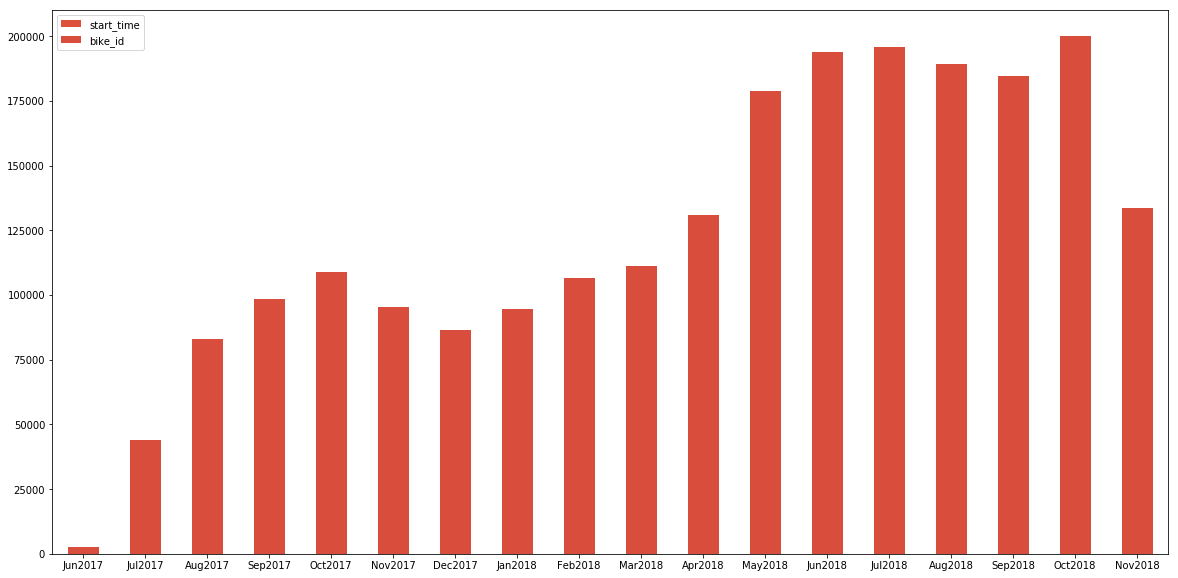

In [222]:
# Plot the data
fig, ax = plt.subplots(figsize=(30,10))
labels = ['Jun2017', 'Jul2017', 'Aug2017', 'Sep2017', 'Oct2017', 'Nov2017', 'Dec2017', 'Jan2018', 'Feb2018', 
          'Mar2018', 'Apr2018', 'May2018', 'Jun2018', 'Jul2018', 'Aug2018', 'Sep2018', 'Oct2018', 'Nov2018']

month_year.plot(kind='bar', stacked=True, color=color, figsize=[20,10], ax=ax)
ax.set_xticklabels(labels, rotation=0)

We can see that July 2017 has a very small amount of ridership. That's because Ford Go Bikeshare started in July 2017 (https://www.fordgobike.com/blog/missionsurvey). <br>
Although July has very low ridership, we can see 2 things in this graph: 
1. Seasonality. Ridership begins to decrease in the winter months and increase in the summer months. 
2. Growth in Ridership. We can see that overall ridership for Ford Go Bikeshare is increasing

<br>

### Subscriber vs. Customer <a class="anchor" id="sub_vs_cust"></a>

In [211]:
# Create duration DF
duration_df = df_clean[['duration_sec', 'user_type']].copy()

# Add minutes column
duration_df['duration_min'] = duration_df['duration_sec']/60

In [212]:
# Create new dfs for subscriber. Get Average distance
sub_dist  = duration_df[duration_df.user_type == 'Subscriber']
print('Average Duration for Subscriber:', sub_dist.duration_min.mean())

# Create new dfs for customer. Get Average distance
cust_dist  = duration_df[duration_df.user_type == 'Customer']
print('Average Duration for Customer:', cust_dist.duration_min.mean())

Average Duration for Subscriber: 10.887438533799175
Average Duration for Customer: 30.121333854270723


As we could have expected, the subscribers have lower average durations. This makes sense because they are primarily using the bikes for commuting, whereas customers are most likely tourists and are using the bikes to go from destination to destination. <br><br>
Let's quickly compare the density plots for both customers and subscribers. 

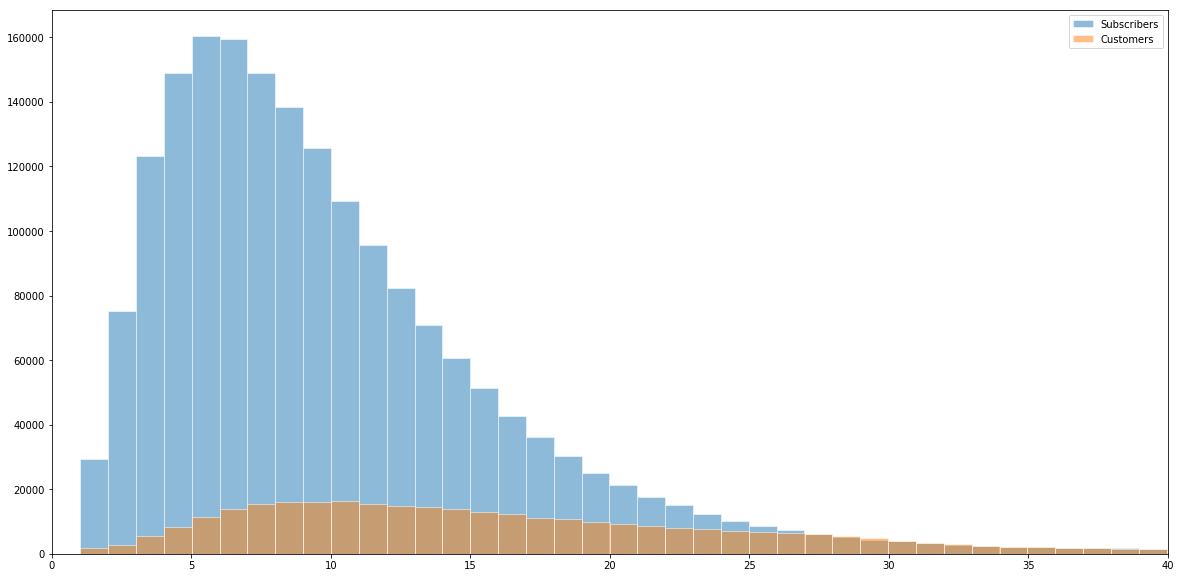

In [218]:
# Density plots for Subscribers and Customers
plt.figure(figsize=(20,10))
plt.hist(sub_dist['duration_min'], bins=720, alpha=0.5, edgecolor='white', label='Subscribers') #719.5 was the largest in both datasets. So, bins = 720 
plt.hist(cust_dist['duration_min'], bins=720, alpha=0.5, edgecolor='white', label='Customers')
plt.legend(loc='upper right')
plt.xlim(0, 40)
plt.show()

A few things to notice here: 
1. This plot includes both customers (orange) and subscribers (blue). 
2. The plot starts at 1 min. This is because we removed all values < 1 minute. We did this because any single ride that is less than 1 minute was most likely an accidental purchase or data entry error. If the bike ride is less than 5 minutes, then walking to the destination could arguably be quicker. 
3. There is a long tail in this plot, but I cut it off so we can get a better look at the distribution. 

Now we can see that there is a sharp difference betweek customers and subscribers. The distribution for customers is almost uniform, whereas the subscribers looks like a Pareto distribution. Most rides fall between 3 minutes and 10 minutes for subscribers. This tells us that most people are riding the bikes for short distances. 

In [336]:
# Create Customer Dataframe
cust_df = df_clean[df_clean['user_type'] == 'Customer']

# Create Subscriber Dataframe
sub_df = df_clean[df_clean['user_type'] == 'Subscriber']

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

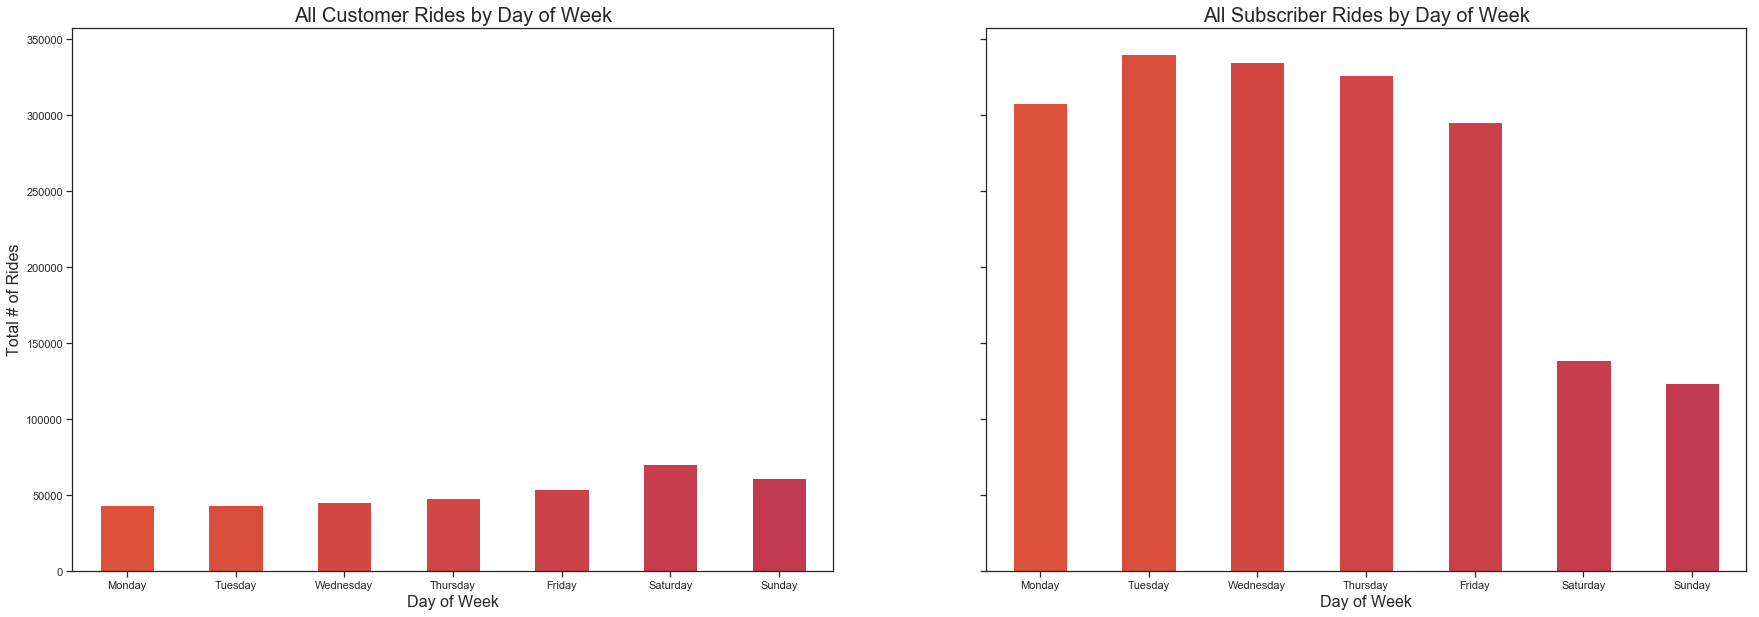

In [341]:
# Now let's look at the number of rides by the timeframe
# Setup the subplot settings
fig, (ax5, ax6) = plt.subplots(ncols=2, nrows=1, figsize=(30,10), sharey=True)
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a Plot that counts the number of Cust Rides by DOW
cust_rides_by_day = cust_df.start_time.dt.weekday.value_counts().sort_index()
cust_rides_by_day.plot(kind='bar', stacked=True, color=color, ax=ax5)
ax5.set_title('All Customer Rides by Day of Week', fontsize=20)
ax5.set_ylabel('Total # of Rides', fontsize=16)
ax5.set_xlabel('Day of Week', fontsize=16)
ax5.set_xticklabels(weekdays, rotation=0)

# Create a Plot that counts the number of Sub Rides by DOW
sub_rides_by_day = sub_df.start_time.dt.weekday.value_counts().sort_index()
sub_rides_by_day.plot(kind='bar', stacked=True, color=color, ax=ax6)
ax6.set_title('All Subscriber Rides by Day of Week', fontsize=20)
ax6.set_ylabel('Total # of Rides', fontsize=16)
ax6.set_xlabel('Day of Week', fontsize=16)
ax6.set_xticklabels(weekdays, rotation=0)

I expected that there would be a larger spike in the Customer Rides graph on Friday, Saturday, & Sunday but that is clearly not the case here. The Customer rides are relatively uniform, with a small spike on Saturday. <br>
As we could have expected with the Subscriber rides, there is a sharp decline on Saturday & Sunday. This is most likely due to subscribers use the service for commuting. <br><br>
Let's look at the duration for customers and subscribers per day of the week

In [354]:
cust_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_min
14,755,2018-11-30 23:46:53.339,2018-11-30 23:59:28.847,211.0,Broadway at 40th St,37.827757,-122.256716,272.0,Woolsey St at Sacramento St,37.850578,-122.278175,2180,Customer,1987.0,Male,No,12.583333
17,599,2018-11-30 23:47:49.572,2018-11-30 23:57:48.772,340.0,Harmon St at Adeline St,37.849735,-122.270582,157.0,65th St at Hollis St,37.846784,-122.291376,1048,Customer,1996.0,Male,No,9.983333
32,354,2018-11-30 23:33:04.558,2018-11-30 23:38:59.057,195.0,Bay Pl at Vernon St,37.812314,-122.260779,372.0,Madison St at 17th St,37.804037,-122.262409,2419,Customer,1987.0,Male,No,5.900000
41,2517,2018-11-30 22:50:06.443,2018-11-30 23:32:03.746,50.0,2nd St at Townsend St,37.780526,-122.390288,371.0,Lombard St at Columbus Ave,37.802746,-122.413579,2711,Customer,1996.0,Male,No,41.950000
46,926,2018-11-30 23:12:23.778,2018-11-30 23:27:50.183,88.0,11th St at Bryant St,37.770030,-122.411726,141.0,Valencia St at Cesar Chavez St,37.747998,-122.420219,1057,Customer,1989.0,Male,No,15.433333


In [355]:
# Create new Weekday Columns
cust_df['weekday'] = cust_df['start_time'].apply(lambda x: x.weekday())
sub_df['weekday'] = sub_df['start_time'].apply(lambda x: x.weekday())

# Create groupby dataframes
cust_groupby = cust_df.groupby('weekday')['duration_min'].mean().reset_index()
sub_groupby = sub_df.groupby('weekday')['duration_min'].mean().reset_index()

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

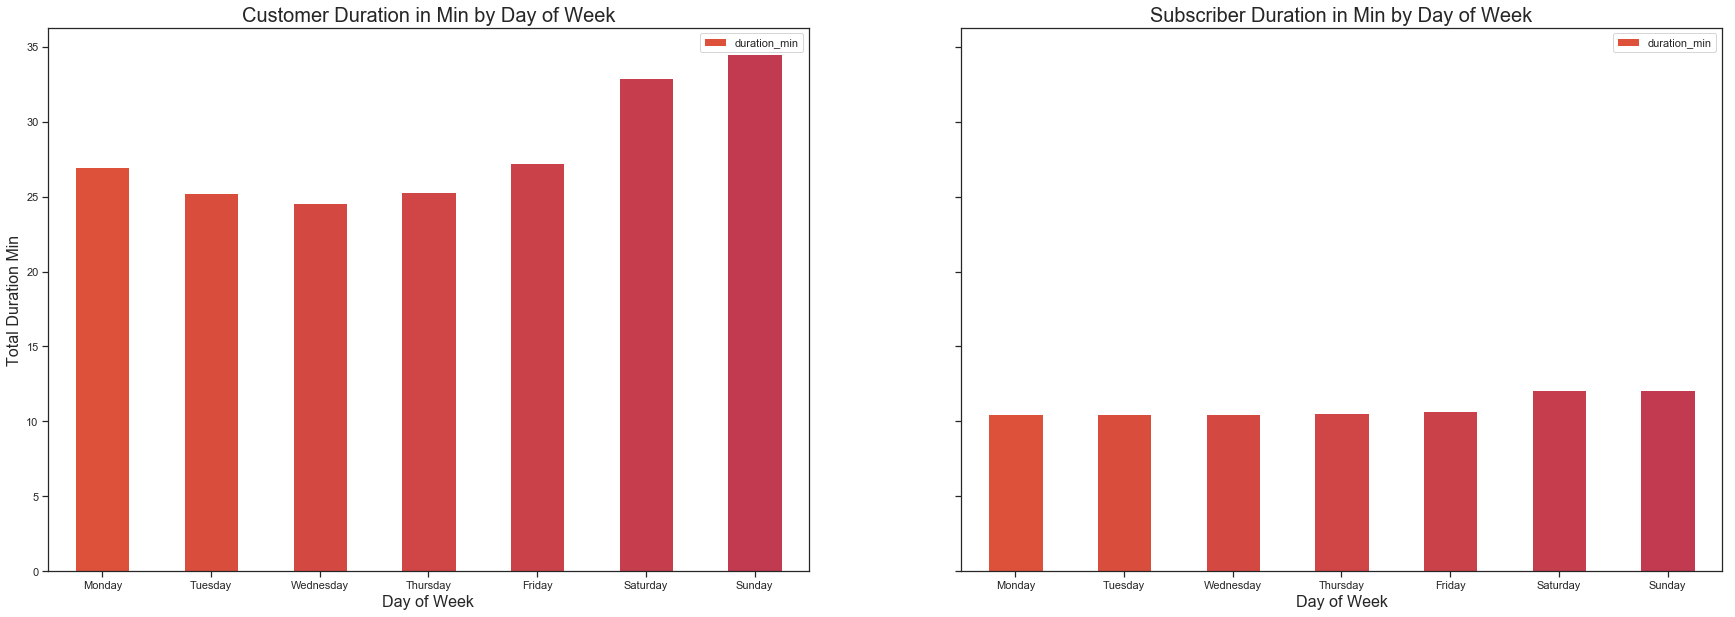

In [385]:
# Setup the subplot settings
fig, (ax7, ax8) = plt.subplots(ncols=2, nrows=1, figsize=(30,10), sharey=True)
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a Plot that counts the number of Cust Duration by DOW
cust_groupby.plot(x='weekday', y='duration_min', kind='bar', sharey=True, color=color, ax=ax7)
ax7.set_title('Customer Duration in Min by Day of Week', fontsize=20)
ax7.set_ylabel('Total Duration Min', fontsize=16)
ax7.set_xlabel('Day of Week', fontsize=16)
ax7.set_xticklabels(weekdays, rotation=0)

# Create a Plot that counts the number of Sub Duration by DOW
sub_groupby.plot(x='weekday', y='duration_min', kind='bar', sharey=True, color=color, ax=ax8)
ax8.set_title('Subscriber Duration in Min by Day of Week', fontsize=20)
ax8.set_ylabel('Total Duration Min', fontsize=16)
ax8.set_xlabel('Day of Week', fontsize=16)
ax8.set_xticklabels(weekdays, rotation=0)

Customer duration in minutes is higher on Saturday & Sunday, with spikes on Monday as well. The longer duration on Sat & Sunday makes intuitive sense, but the spike in Monday seems a bit strange. It could be that the spike has to do with people using the service to get to work on Monday and not all people in the customer dataframe are tourists. 

<br>

### Age <a class="anchor" id="age"></a>

Let's take a look at age first. 

In [223]:
# Create new df for age
age_df = df_clean[['duration_sec', 'user_type', 'member_birth_year', 'member_gender', 'bike_share_for_all_trip', 'start_time']].copy()

# Create new columns for age and duration_min
# note that this is the approx age since we only have birth year and not month & day
age_df['duration_min'] = age_df['duration_sec'] / 60
age_df['approx_age'] = 2018 - age_df['member_birth_year']

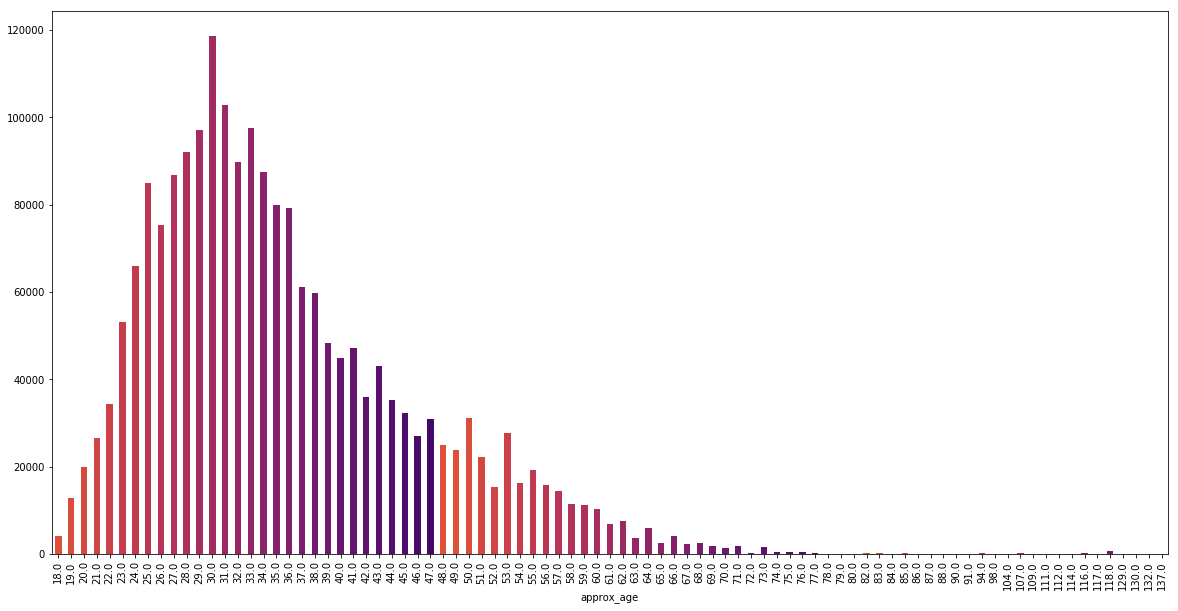

In [224]:
age_groupby = age_df.groupby('approx_age')['member_birth_year'].count()
age_groupby.plot(kind='bar', stacked=True, color=color, figsize=[20,10])

We can see right away there are some outliers. There are also a significant amount of null values. <br>
We can also see that 30 years old is the most common in the dataset. A better way to view this information would be to bin the ages.  

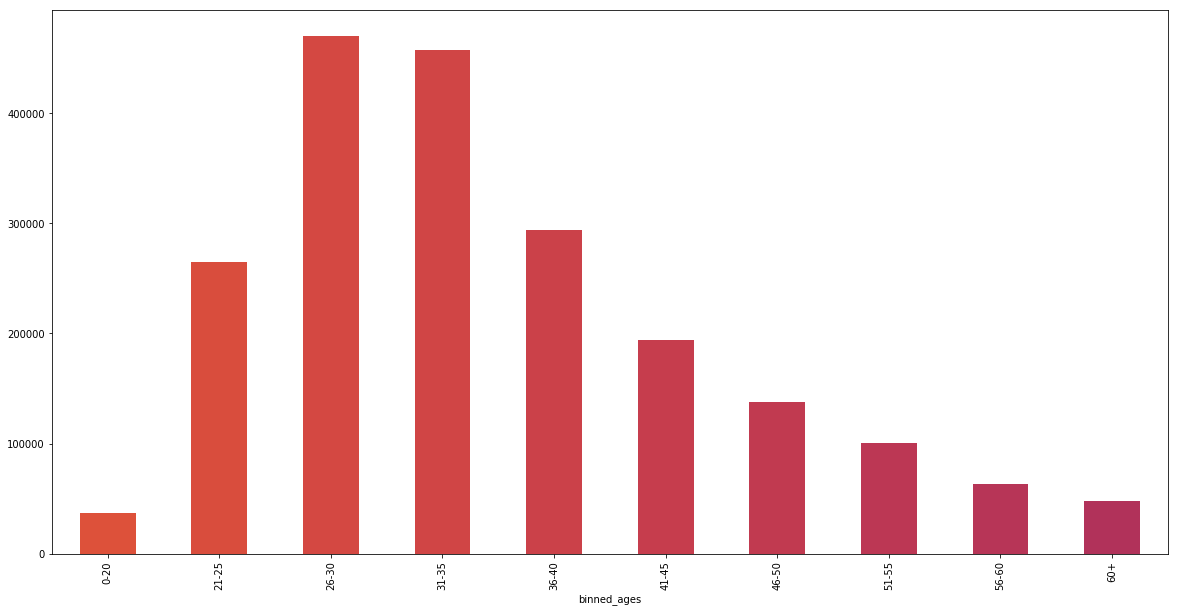

In [225]:
# Create new column for binned age
age_df['binned_ages'] = pd.cut(age_df['approx_age'], [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 999], 
                       labels=['0-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '60+'])

# Frequency count for binned_ages
binned_ages = age_df.groupby('binned_ages')['approx_age'].count()
binned_ages.plot(kind='bar', stacked=True, color=color, figsize=[20,10])

The majority of the people int the dataset are between the ages of 26 and 40. Intuitively, this makes sense since we believe the majority of subscribers are working professionals that use the service to commute to work. Let's take a look at the user types by binned age. 

In [226]:
# new dfs for customers & subscribers
sub_by_age = age_df[age_df['user_type'] == 'Subscriber']
cust_by_age = age_df[age_df['user_type'] == 'Customer']

# Frequency count for binned_ages
age_sub = sub_by_age.groupby(['binned_ages'])['approx_age'].count()
age_cust = cust_by_age.groupby(['binned_ages'])['approx_age'].count()

Text(0.5, 0, 'Age Group')

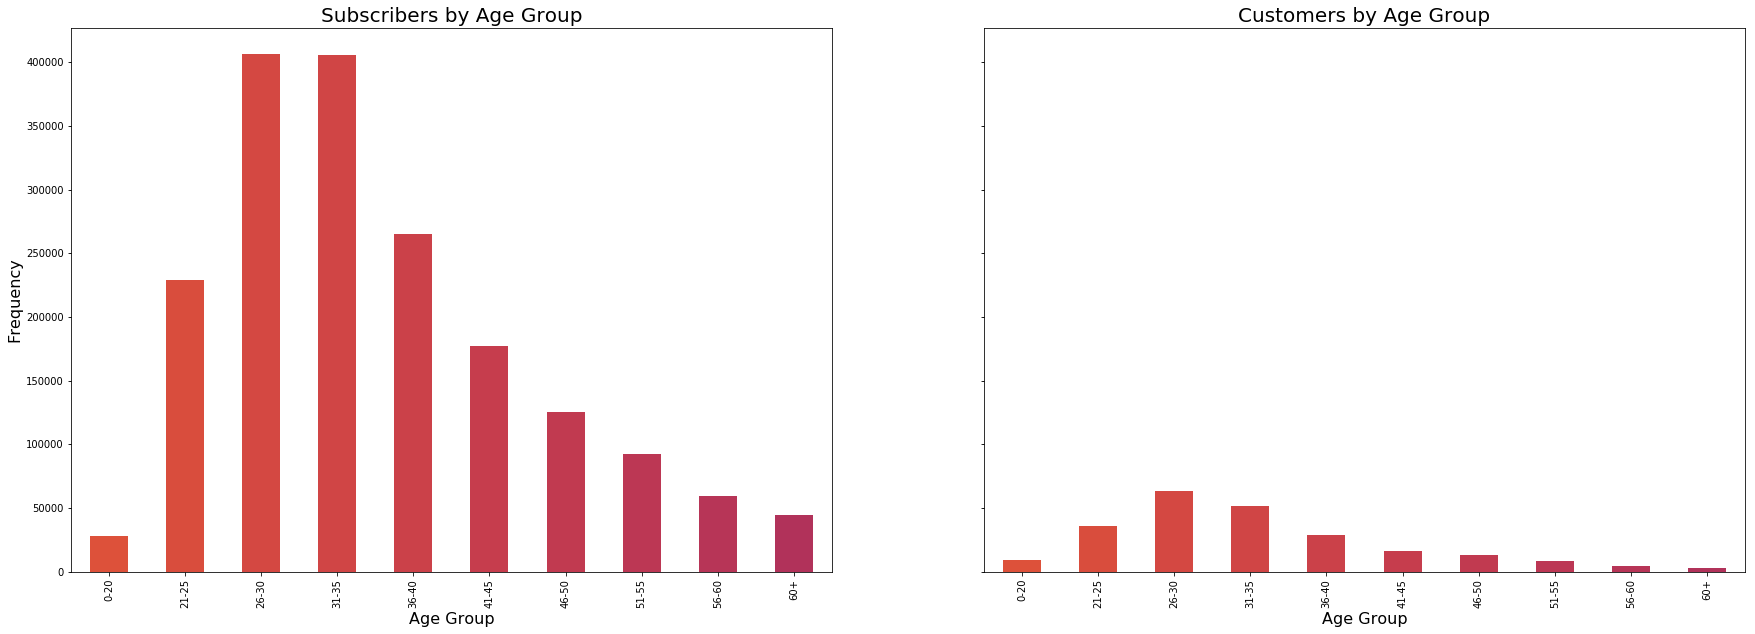

In [227]:
# Now let's look at the number of rides by the timeframe
# Setup the subplot settings
fig, (ax7, ax8) = plt.subplots(ncols=2, nrows=1, figsize=(30,10), sharey=True)

# Create a Plot that counts the number of hires by Day of Week
age_sub.plot(kind='bar', stacked=True, color=color, ax=ax7)
ax7.set_title('Subscribers by Age Group', fontsize=20)
ax7.set_ylabel('Frequency', fontsize=16)
ax7.set_xlabel('Age Group', fontsize=16)

# Create a Plot that counts the number of hires by Hour of Day
age_cust.plot(kind='bar', stacked=True, color=color, ax=ax8)
ax8.set_title('Customers by Age Group', fontsize=20)
ax8.set_ylabel('Frequency', fontsize=16)
ax8.set_xlabel('Age Group', fontsize=16)

Between the two graphs, there is not much of a difference. The majority of riders still fall within the age range of 26-40 years old. One thing to note is the slight increase in riders between the ages of 0-20. Younger could mean travelers, but this is a stretch. We would need more information before making a claim like this. 

<br>

### Subscriber vs Customer <a class="anchor" id="Subscriber vs Customer"></a>

<br>

### Gender <a class="anchor" id="gender"></a>

In [246]:
# Percentages of Mele vs Female
age_df['member_gender'].value_counts() / df_clean['member_gender'].count()

Male      0.741098
Female    0.243807
Other     0.015095
Name: member_gender, dtype: float64

In the dataset, we have approximately 75% men and 25% women. There are missing values here, but we will ignore those for now. Just like we did above, let's look at the agr groups by gender.

In [247]:
# new dfs for customers & subscribers
female_by_age = age_df[age_df['member_gender'] == 'Female']
male_by_age = age_df[age_df['member_gender'] == 'Male']

# Frequency count for binned_ages
age_female = female_by_age.groupby(['binned_ages'])['approx_age'].count()
age_male = male_by_age.groupby(['binned_ages'])['approx_age'].count()

Text(0.5, 0, 'Age Group')

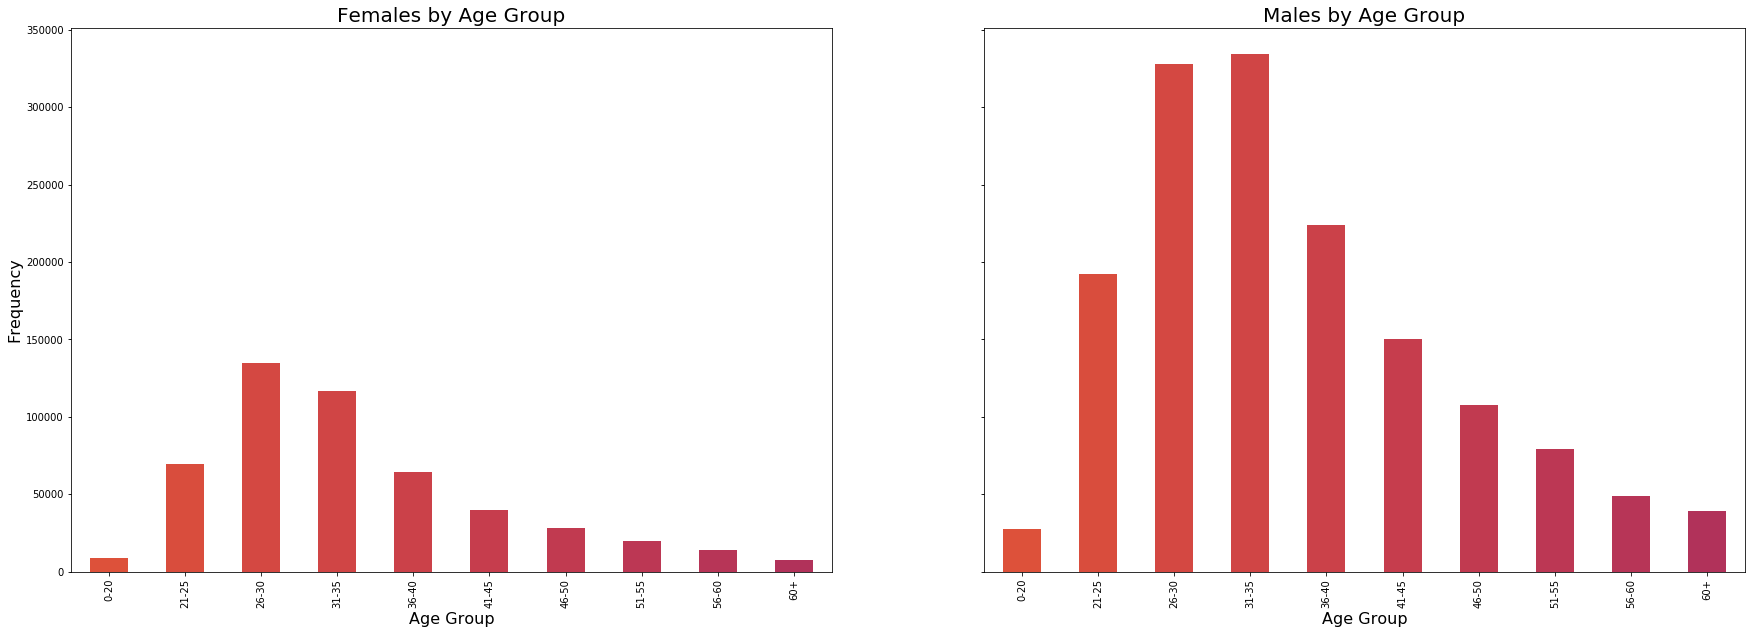

In [248]:
# Now let's look at the number of rides by the timeframe
# Setup the subplot settings
fig, (ax9, ax10) = plt.subplots(ncols=2, nrows=1, figsize=(30,10), sharey=True)

# Create a Plot that counts the number of hires by Day of Week
age_female.plot(kind='bar', stacked=True, color=color, ax=ax9)
ax9.set_title('Females by Age Group', fontsize=20)
ax9.set_ylabel('Frequency', fontsize=16)
ax9.set_xlabel('Age Group', fontsize=16)

# Create a Plot that counts the number of hires by Hour of Day
age_male.plot(kind='bar', stacked=True, color=color, ax=ax10)
ax10.set_title('Males by Age Group', fontsize=20)
ax10.set_ylabel('Frequency', fontsize=16)
ax10.set_xlabel('Age Group', fontsize=16)

No real insight here. The age distributions between females & males very similar. Let's keep digging into this and check rider habits. First, let's check the growth rates for both men and women. 

In [259]:
# Create 2017 & 2018 df for women
female2017 = age_df[(age_df.start_time.dt.year == 2017) & (age_df.member_gender == 'Female')]
female2018 = age_df[(age_df.start_time.dt.year == 2018) & (age_df.member_gender == 'Female')]

# Groupby month
female_month2017 = female2017.groupby(female2017.start_time.dt.month)['duration_sec'].count()
female_month2018 = female2018.groupby(female2018.start_time.dt.month)['duration_sec'].count()

# Concat & Reset Index
female_month_year = pd.concat([female_month2017, female_month2018], axis=0).reset_index()

In [263]:
# Create 2017 & 2018 df for women
male2017 = age_df[(age_df.start_time.dt.year == 2017) & (age_df.member_gender == 'Male')]
male2018 = age_df[(age_df.start_time.dt.year == 2018) & (age_df.member_gender == 'Male')]

# Groupby month
male_month2017 = male2017.groupby(male2017.start_time.dt.month)['duration_sec'].count()
male_month2018 = male2018.groupby(male2018.start_time.dt.month)['duration_sec'].count()

# Concat & Reset Index
male_month_year = pd.concat([male_month2017, male_month2018], axis=0).reset_index()

[Text(0, 0, 'Jun2017'),
 Text(0, 0, 'Jul2017'),
 Text(0, 0, 'Aug2017'),
 Text(0, 0, 'Sep2017'),
 Text(0, 0, 'Oct2017'),
 Text(0, 0, 'Nov2017'),
 Text(0, 0, 'Dec2017'),
 Text(0, 0, 'Jan2018'),
 Text(0, 0, 'Feb2018'),
 Text(0, 0, 'Mar2018'),
 Text(0, 0, 'Apr2018'),
 Text(0, 0, 'May2018'),
 Text(0, 0, 'Jun2018'),
 Text(0, 0, 'Jul2018'),
 Text(0, 0, 'Aug2018'),
 Text(0, 0, 'Sep2018'),
 Text(0, 0, 'Oct2018'),
 Text(0, 0, 'Nov2018')]

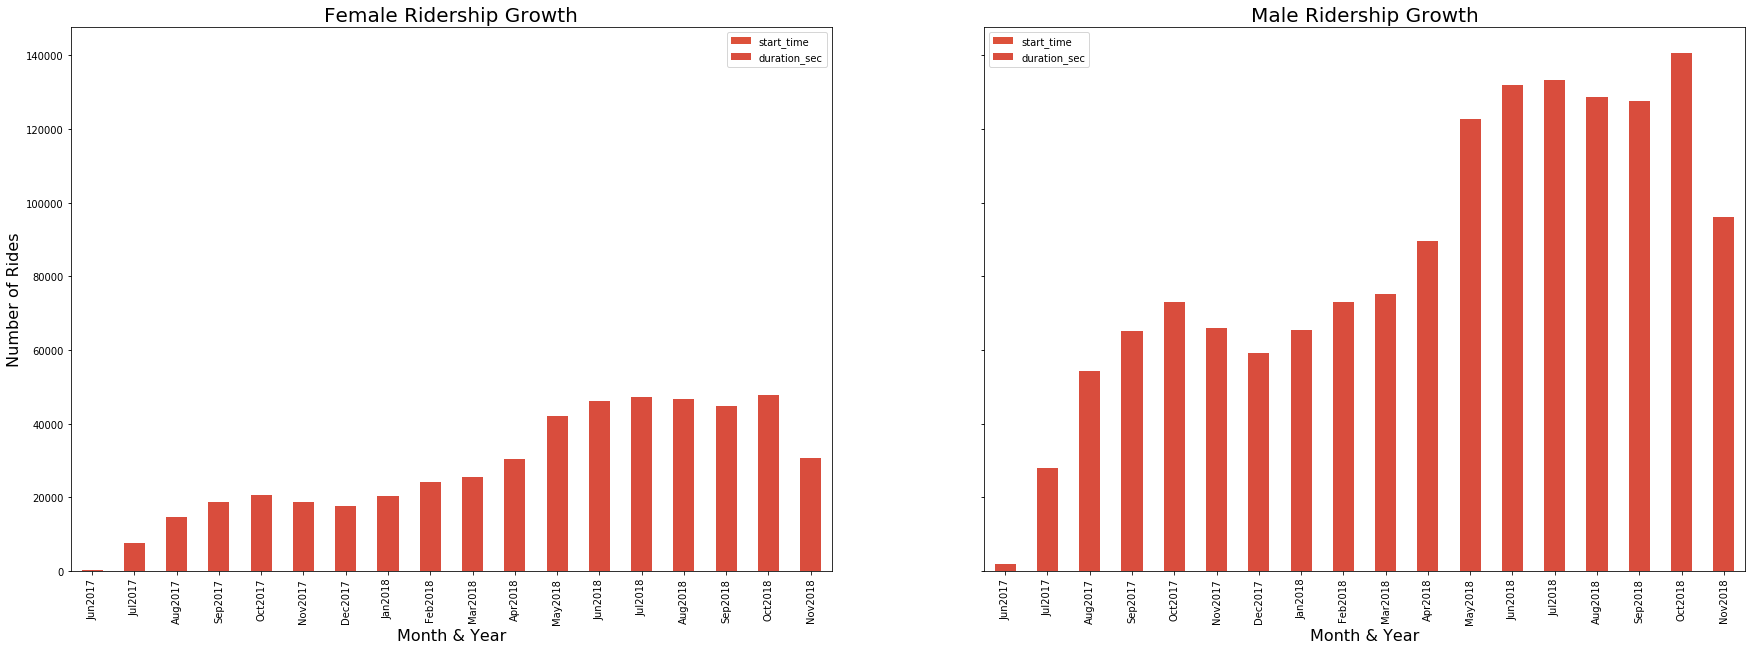

In [264]:
# Plot the data
fig, (ax11, ax12) = plt.subplots(ncols=2, nrows=1, figsize=(30,10), sharey=True)
labels = ['Jun2017', 'Jul2017', 'Aug2017', 'Sep2017', 'Oct2017', 'Nov2017', 'Dec2017', 'Jan2018', 'Feb2018', 
          'Mar2018', 'Apr2018', 'May2018', 'Jun2018', 'Jul2018', 'Aug2018', 'Sep2018', 'Oct2018', 'Nov2018']

# Women graph
women_month_year.plot(kind='bar', stacked=True, color=color, ax=ax1)
ax11.set_title('Female Ridership Growth', fontsize=20)
ax11.set_ylabel('Number of Rides', fontsize=16)
ax11.set_xlabel('Month & Year', fontsize=16)
ax11.set_xticklabels(labels, rotation=90)

# Men Graph
male_month_year.plot(kind='bar', stacked=True, color=color, ax=ax12)
ax12.set_title('Male Ridership Growth', fontsize=20)
ax12.set_ylabel('Number of Rides', fontsize=16)
ax12.set_xlabel('Month & Year', fontsize=16)
ax12.set_xticklabels(labels, rotation=90)

Interesting! We can see an upward trend along with seasonaility in the Female & Male Ridership Growth. <br>